In [1]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()


# 3D Ising model
def ising3D(J, h, T, N, M, n):
    """3D Ising model using Metropolis algorithm

    input:
        J: interaction energy
        h: external magnetic field
        T: temperature
        N: size of the spin lattice
        M: number of Monte Carlo steps
        n: number of samples to calculate average

    output:
        E_avg: average energy at temperature T
        M_avg: average magnetization at temperature T
        C: specific heat at temperature T
        X: susceptibility initialize at temperature T
    """
    # initialize
    spins = rng.choice([-1, 1], size=(N, N, N))  # random spin initialization
    # spins = np.ones((N, N, N))  # all spin up initialization

    # periodic boundary condition
    # E = interaction energy with up/down/left/right/forward/backward neighbors + external field energy
    up = np.roll(spins, 1, axis=0)
    down = np.roll(spins, -1, axis=0)
    left = np.roll(spins, 1, axis=1)
    right = np.roll(spins, -1, axis=1)
    forward = np.roll(spins, 1, axis=2)
    backward = np.roll(spins, -1, axis=2)
    E = -J * (np.sum(spins * up) + np.sum(spins * down) + np.sum(spins * left) + np.sum(spins * right) + np.sum(spins * forward) + np.sum(spins * backward)) - h * np.sum(spins)

    E_list = np.zeros(M)  # list of energy after per N**3 Monte Carlo step
    M_list = np.zeros(M)  # list of magnetization after per N**3 Monte Carlo step

    # Metropolis algorithm
    for i in range(M):
        for j in range(N**3):
            # randomly choose a spin
            x = rng.integers(N)
            y = rng.integers(N)
            z = rng.integers(N)

            # calculate energy difference
            # 2*spins[x, y, z] is the energy of the spin itself
            delta_E = (
                J * 2 * spins[x, y, z] * (spins[x + 1 - N, y, z] + spins[x - 1, y, z] + spins[x, y + 1 - N, z] + spins[x, y - 1, z] + spins[x, y, z + 1 - N] + spins[x, y, z - 1])
                + h * 2 * spins[x, y, z]
            )

            # flip
            if delta_E < 0 or rng.random() < np.exp(-delta_E / T):
                spins[x, y, z] *= -1
                E += delta_E

        E_list[i] = E
        M_list[i] = np.sum(spins)

    # average
    E_avg = np.average(E_list[n:])
    M_avg = np.average(M_list[n:])
    C = np.var(E_list[n:]) / T**2
    X = np.var(M_list[n:]) / T

    return E_avg, M_avg, C, X

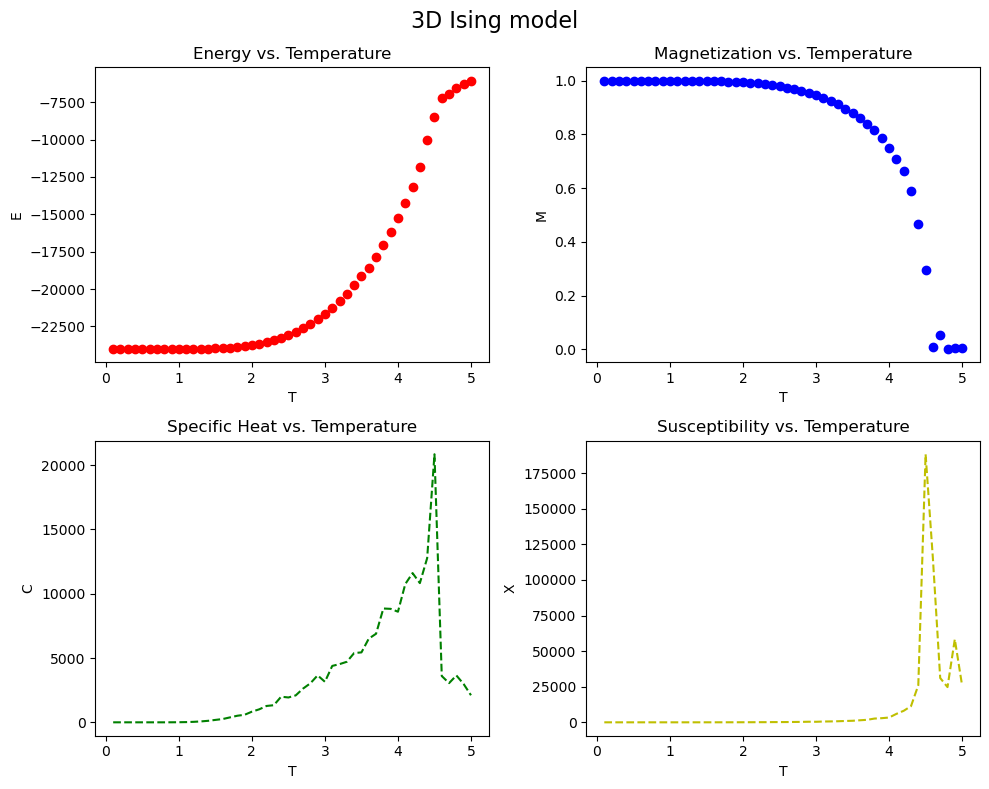

In [2]:
# 3D Ising model
J = 1
h = 0
N = 20
M = 1000
n = 500

T_list = np.linspace(0.1, 5, 15)
E_list = np.zeros(len(T_list))
M_list = np.zeros(len(T_list))
C_list = np.zeros(len(T_list))
X_list = np.zeros(len(T_list))

for i in range(len(T_list)):
    E_list[i], M_list[i], C_list[i], X_list[i] = ising3D(J, h, T_list[i], N, M, n)

# save data to txt file
np.savetxt("T_list3D.txt", T_list)
np.savetxt("E_list3D.txt", E_list)
np.savetxt("M_list3D.txt", M_list)
np.savetxt("C_list3D.txt", C_list)
np.savetxt("X_list3D.txt", X_list)

######################################################################################################

# read data from txt file
T_list = np.loadtxt("./data/3D_demo/T_list3D.txt")
E_list = np.loadtxt("./data/3D_demo/E_list3D.txt")
M_list = np.loadtxt("./data/3D_demo/M_list3D.txt")
C_list = np.loadtxt("./data/3D_demo/C_list3D.txt")
X_list = np.loadtxt("./data/3D_demo/X_list3D.txt")


# for i in range(31, 32):
#     E_list[i], M_list[i], C_list[i], X_list[i] = ising3D(J, h, T_list[i], N, M, n)


# plot
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("3D Ising model", fontsize=16)

ax1.set_title("Energy vs. Temperature")
ax1.set_xlabel("T")
ax1.set_ylabel("E")
# ax1.plot(T_list, E_list, 'r--')
ax1.scatter(T_list, E_list, c="r")

ax2.set_title("Magnetization vs. Temperature")
ax2.set_xlabel("T")
ax2.set_ylabel("M")
# ax2.plot(T_list, abs(M_list) / N**3, 'b--')
ax2.scatter(T_list, abs(M_list) / N**3, c="b")

ax3.set_title("Specific Heat vs. Temperature")
ax3.set_xlabel("T")
ax3.set_ylabel("C")
ax3.plot(T_list, C_list, "g--")

ax4.set_title("Susceptibility vs. Temperature")
ax4.set_xlabel("T")
ax4.set_ylabel("X")
ax4.plot(T_list, X_list, "y--")

plt.tight_layout()
plt.show()

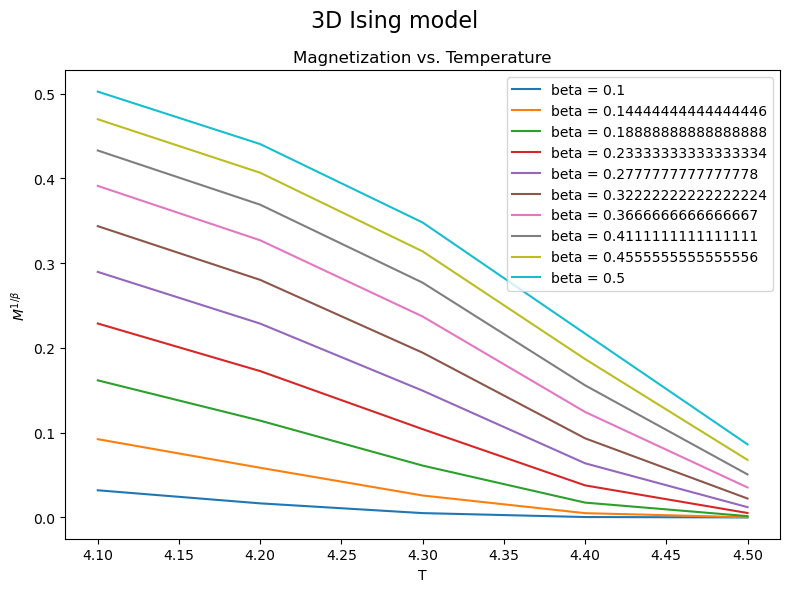

In [3]:
# beta fitting
T_list = np.loadtxt("./data/3D_demo/T_list3D.txt")
M_list = np.loadtxt("./data/3D_demo/M_list3D.txt")


fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("3D Ising model", fontsize=16)

ax.set_title("Magnetization vs. Temperature")
ax.set_xlabel("T")
ax.set_ylabel("$M^{1/\\beta}$")

begin = 40
end = 45
T_list = T_list[begin:end]
M_list = abs(M_list[begin:end]) / N**3

for beta in np.linspace(0.1, 0.5, 10):
    ax.plot(T_list, M_list ** (1 / beta), label="beta = " + str(beta))

ax.legend()

plt.tight_layout()
plt.show()

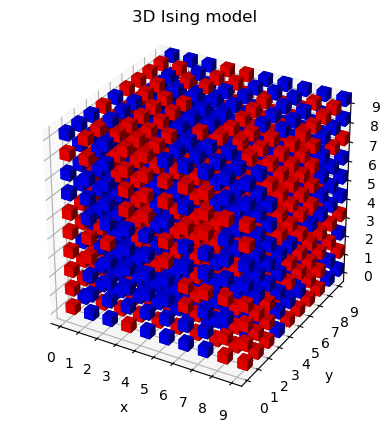

In [4]:
from matplotlib.animation import FuncAnimation


# 3D Ising model, spin animation
J = 1
h = 0
N = 10
M = 100

T = 4.5

# initialize
spins = rng.choice([-1, 1], size=(N, N, N))  # random spin initialization

E = -J * (
    np.sum(spins * np.roll(spins, 1, axis=0))  # interaction energy with up/down neighbors (periodic boundary condition)
    + np.sum(spins * np.roll(spins, 1, axis=1))  # interaction energy with left/right neighbors (periodic boundary condition)
    + np.sum(spins * np.roll(spins, 1, axis=2))  # interaction energy with front/back neighbors (periodic boundary condition)
) - h * np.sum(spins)  # external field energy


# animation
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


ax.set_title("3D Ising model")
ax.set_aspect("equal")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-0.5, N - 0.5)
ax.set_ylim(-0.5, N - 0.5)
ax.set_zlim(-0.5, N - 0.5)

ax.set_xticks(np.arange(0, N, 1))
ax.set_yticks(np.arange(0, N, 1))
ax.set_zticks(np.arange(0, N, 1))


def voxel_plot(ax, spins: np.ndarray):
    # x, y, z = np.indices(spins.shape)
    # x = x.flatten()
    # y = y.flatten()
    # z = z.flatten()

    # dx = 0.25 * np.ones_like(x)
    # dy = dx.copy()
    # dz = dx.copy()

    # ax.bar3d(x, y, z, dx, dy, dz, color="b", zsort="average")

    for i in range(N):
        for j in range(N):
            for k in range(N):
                if spins[i, j, k] == 1:
                    ax.bar3d(i, j, k, 0.5, 0.5, 0.5, color="b", zsort="average")
                else:
                    ax.bar3d(i, j, k, 0.5, 0.5, 0.5, color="r", zsort="average")

    return ax


def update(i):
    # Monte Carlo
    for j in range(N**3):
        # randomly choose a spin
        x = rng.integers(N)
        y = rng.integers(N)
        z = rng.integers(N)

        # calculate energy difference
        delta_E = (
            J * 2 * spins[x, y, z] * (spins[(x + 1) % N, y, z] + spins[(x - 1) % N, y, z] + spins[x, (y + 1) % N, z] + spins[x, (y - 1) % N, z] + spins[x, y, (z + 1) % N] + spins[x, y, (z - 1) % N])
            + h * 2 * spins[x, y, z]
        )  # mod N is periodic boundary condition, 2*spins[x, y, z] is the energy of the spin itself

        # Metropolis flip algorithm
        if delta_E < 0 or rng.random() < np.exp(-delta_E / T):
            spins[x, y, z] *= -1

    # plot
    ax.clear()
    ax.set_title("3D Ising model")
    ax.set_aspect("equal")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.set_zlim(-0.5, N - 0.5)

    ax.set_xticks(np.arange(0, N, 1))
    ax.set_yticks(np.arange(0, N, 1))
    ax.set_zticks(np.arange(0, N, 1))

    voxel_plot(ax, spins)
    return ax


anim = FuncAnimation(fig, update, frames=M, interval=200, repeat=False)
anim.save("3D_Ising_model.gif", writer="pillow", fps=10)